In [ ]:
from ast import literal_eval
from Statistics_and_Seq2Seq.all_functions import *
import os
from cisia.datasets import DatasetLoader
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.clustering.averaging import elastic_barycenter_average
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
def get_preds_column(df):
    df['predictions'] = df['predictions'].str.replace(r'\s+', ', ', regex=True)  # Substitui espaços múltiplos por vírgulas
    df['predictions'] = df['predictions'].str.replace(r'^\[\s*,', '[', regex=True)  # Remove a vírgula inicial, se existir
    df['predictions'] = df['predictions'].apply(lambda x: literal_eval(x.strip()))  # Converte para lista usando literal_eval
    return df['predictions'].tolist()[0]

def get_preds_column(df, test_index):
    df['predictions'] = df['predictions'].str.replace(r'\s+', ', ', regex=True)  # Substitui espaços múltiplos por vírgulas
    df['predictions'] = df['predictions'].str.replace(r'^\[\s*,', '[', regex=True)  # Remove a vírgula inicial, se existir
    df['predictions'] = df['predictions'].apply(lambda x: literal_eval(x.strip()))  # Converte para lista usando literal_eval
    return pd.Series(df['predictions'].tolist()[0], index=test_index)

def calculate_mean_prediction(*predictions):
    """
    Calcula a predição média com base em várias predições fornecidas como argumentos.
    """
    # Converte todas as predições para arrays numpy
    pred_arrays = [np.array(pred) for pred in predictions]
    # Calcula a média ao longo do eixo 0 (por passo do tempo)
    mean_prediction = np.mean(pred_arrays, axis=0)
    return mean_prediction

def calculate_median_prediction(*predictions):
    """
    Calcula a predição média com base em várias predições fornecidas como argumentos.
    """
    # Converte todas as predições para arrays numpy
    pred_arrays = [np.array(pred) for pred in predictions]
    # Calcula a média ao longo do eixo 0 (por passo do tempo)
    mean_prediction = np.median(pred_arrays, axis=0)
    return mean_prediction

horizon = 12
exp_name = "DBA_ALL2"

path_experiments = f'./timeseries/mestrado/resultados/{exp_name}/'
path_csv = f"{path_experiments}/ANP_MONTHLY.csv"
os.makedirs(path_experiments, exist_ok=True)

rmses, smapes, msmapes, maes, mapes, pocids = [], [], [], [], [], []
cols_serie = ["dataset_index", "horizon","regressor", "mape", "pocid", "smape", "rmse", "msmape", "mae", "test", "predictions", 'start_test', 'final_test']
cols_dataset = ["dataset", "regressor", "mape_mean", "pocid_mean", "smape_mean", "rmse_mean", "msmape_mean", "mae_mean"]
date_target = '2024-11-30'

loader = DatasetLoader()
# result, flag = loader.sales_monthly_state()
# print(flag)
df_original, metadata = loader.read_tsf(path_tsf='./mes_11_venda_mensal.tsf')
series_value = df_original.iloc[2]['series_value'].tolist()
start_timestamp = df_original.iloc[2]['start_timestamp']
index_series = pd.date_range(start=start_timestamp, periods=len(series_value), freq="M")

pd_series = pd.Series(series_value, index=index_series)
_, get = pd_series[:-horizon], pd_series[-horizon:]


for index in range(182):
    preds_barycenter = []
    # preds_elastic = []

    df_arima = pd.read_csv('./timeseries/mestrado/resultados/ARIMA/normal/ANP_MONTHLY.csv', sep=";")
    df_arima = df_arima[df_arima['dataset_index'] == index]
    df_arima = df_arima[df_arima['final_test'] == date_target]

    df_catboost = pd.read_csv('./timeseries/mestrado/resultados/catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_catboost = df_catboost[df_catboost['dataset_index'] == index]
    df_catboost = df_catboost[df_catboost['final_test'] == date_target]

    df_cwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/CWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_cwt_catboost = df_cwt_catboost[df_cwt_catboost['dataset_index'] == index]
    df_cwt_catboost = df_cwt_catboost[df_cwt_catboost['final_test'] == date_target]

    df_cwt_rf = pd.read_csv('./timeseries/mestrado/resultados/CWT_rf/normal/ANP_MONTHLY.csv', sep=";")
    df_cwt_rf = df_cwt_rf[df_cwt_rf['dataset_index'] == index]
    df_cwt_rf = df_cwt_rf[df_cwt_rf['final_test'] == date_target]

    df_cwt_svr = pd.read_csv('./timeseries/mestrado/resultados/CWT_svr/normal/ANP_MONTHLY.csv', sep=";")
    df_cwt_svr = df_cwt_svr[df_cwt_svr['dataset_index'] == index]
    df_cwt_svr = df_cwt_svr[df_cwt_svr['final_test'] == date_target]

    df_dwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/DWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_dwt_catboost = df_dwt_catboost[df_dwt_catboost['dataset_index'] == index]
    df_dwt_catboost = df_dwt_catboost[df_dwt_catboost['final_test'] == date_target]

    df_dwt_rf = pd.read_csv('./timeseries/mestrado/resultados/DWT_rf/normal/ANP_MONTHLY.csv', sep=";")
    df_dwt_rf = df_dwt_rf[df_dwt_rf['dataset_index'] == index]
    df_dwt_rf = df_dwt_rf[df_dwt_rf['final_test'] == date_target]

    df_dwt_svr = pd.read_csv('./timeseries/mestrado/resultados/DWT_svr/normal/ANP_MONTHLY.csv', sep=";")
    df_dwt_svr = df_dwt_svr[df_dwt_svr['dataset_index'] == index]
    df_dwt_svr = df_dwt_svr[df_dwt_svr['final_test'] == date_target]

    df_ets = pd.read_csv('./timeseries/mestrado/resultados/ETS/normal/ANP_MONTHLY.csv', sep=";")
    df_ets = df_ets[df_ets['dataset_index'] == index]
    df_ets = df_ets[df_ets['final_test'] == date_target]

    df_naivemoving = pd.read_csv('./timeseries/mestrado/resultados/NaiveMovingAverage/normal/ANP_MONTHLY.csv', sep=";")
    df_naivemoving = df_naivemoving[df_naivemoving['dataset_index'] == index]
    df_naivemoving = df_naivemoving[df_naivemoving['final_test'] == date_target]

    df_naiveseasonal = pd.read_csv('./timeseries/mestrado/resultados/NaiveSeasonal/normal/ANP_MONTHLY.csv', sep=";")
    df_naiveseasonal = df_naiveseasonal[df_naiveseasonal['dataset_index'] == index]
    df_naiveseasonal = df_naiveseasonal[df_naiveseasonal['final_test'] == date_target]

    df_nbeats = pd.read_csv('./timeseries/mestrado/resultados/NBEATS/normal/ANP_MONTHLY.csv', sep=";")
    df_nbeats = df_nbeats[df_nbeats['dataset_index'] == index]
    df_nbeats = df_nbeats[df_nbeats['final_test'] == date_target]

    df_only_cwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/ONLY_CWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_only_cwt_catboost = df_only_cwt_catboost[df_only_cwt_catboost['dataset_index'] == index]
    df_only_cwt_catboost = df_only_cwt_catboost[df_only_cwt_catboost['final_test'] == date_target]

    df_only_cwt_rf = pd.read_csv('./timeseries/mestrado/resultados/ONLY_CWT_rf/normal/ANP_MONTHLY.csv', sep=";")
    df_only_cwt_rf = df_only_cwt_rf[df_only_cwt_rf['dataset_index'] == index]
    df_only_cwt_rf = df_only_cwt_rf[df_only_cwt_rf['final_test'] == date_target]

    df_only_cwt_svr = pd.read_csv('./timeseries/mestrado/resultados/ONLY_CWT_svr/normal/ANP_MONTHLY.csv', sep=";")
    df_only_cwt_svr = df_only_cwt_svr[df_only_cwt_svr['dataset_index'] == index]
    df_only_cwt_svr = df_only_cwt_svr[df_only_cwt_svr['final_test'] == date_target]

    df_only_dwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/ONLY_DWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_only_dwt_catboost = df_only_dwt_catboost[df_only_dwt_catboost['dataset_index'] == index]
    df_only_dwt_catboost = df_only_dwt_catboost[df_only_dwt_catboost['final_test'] == date_target]

    df_only_dwt_rf = pd.read_csv('./timeseries/mestrado/resultados/ONLY_DWT_rf/normal/ANP_MONTHLY.csv', sep=";")
    df_only_dwt_rf = df_only_dwt_rf[df_only_dwt_rf['dataset_index'] == index]
    df_only_dwt_rf = df_only_dwt_rf[df_only_dwt_rf['final_test'] == date_target]

    df_only_dwt_svr = pd.read_csv('./timeseries/mestrado/resultados/ONLY_DWT_svr/normal/ANP_MONTHLY.csv', sep=";")
    df_only_dwt_svr = df_only_dwt_svr[df_only_dwt_svr['dataset_index'] == index]
    df_only_dwt_svr = df_only_dwt_svr[df_only_dwt_svr['final_test'] == date_target]

    df_rf = pd.read_csv('./timeseries/mestrado/resultados/rf/normal/ANP_MONTHLY.csv', sep=";")
    df_rf = df_rf[df_rf['dataset_index'] == index]
    df_rf = df_rf[df_rf['final_test'] == date_target]

    df_svr = pd.read_csv('./timeseries/mestrado/resultados/svr/normal/ANP_MONTHLY.csv', sep=";")
    df_svr = df_svr[df_svr['dataset_index'] == index]
    df_svr = df_svr[df_svr['final_test'] == date_target]

    df_theta = pd.read_csv('./timeseries/mestrado/resultados/THETA/normal/ANP_MONTHLY.csv', sep=";")
    df_theta = df_theta[df_theta['dataset_index'] == index]
    df_theta = df_theta[df_theta['final_test'] == date_target]


    df_ft_rf = pd.read_csv('./timeseries/mestrado/resultados/FT_rf/normal/ANP_MONTHLY.csv', sep=";")
    df_ft_rf = df_ft_rf[df_ft_rf['dataset_index'] == index]
    df_ft_rf = df_ft_rf[df_ft_rf['final_test'] == date_target]

    df_ft_catboost = pd.read_csv('./timeseries/mestrado/resultados/FT_catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_ft_catboost = df_ft_catboost[df_ft_catboost['dataset_index'] == index]
    df_ft_catboost = df_ft_catboost[df_ft_catboost['final_test'] == date_target]

    df_ft_svr = pd.read_csv('./timeseries/mestrado/resultados/FT_svr/normal/ANP_MONTHLY.csv', sep=";")
    df_ft_svr = df_ft_svr[df_ft_svr['dataset_index'] == index]
    df_ft_svr = df_ft_svr[df_ft_svr['final_test'] == date_target]

    df_only_ft_rf = pd.read_csv('./timeseries/mestrado/resultados/ONLY_FT_rf/normal/ANP_MONTHLY.csv', sep=";")
    df_only_ft_rf = df_only_ft_rf[df_only_ft_rf['dataset_index'] == index]
    df_only_ft_rf = df_only_ft_rf[df_only_ft_rf['final_test'] == date_target]

    df_only_ft_catboost = pd.read_csv('./timeseries/mestrado/resultados/ONLY_FT_catboost/normal/ANP_MONTHLY.csv', sep=";")
    df_only_ft_catboost = df_only_ft_catboost[df_only_ft_catboost['dataset_index'] == index]
    df_only_ft_catboost = df_only_ft_catboost[df_only_ft_catboost['final_test'] == date_target]

    df_only_ft_svr = pd.read_csv('./timeseries/mestrado/resultados/ONLY_FT_svr/normal/ANP_MONTHLY.csv', sep=";")
    df_only_ft_svr = df_only_ft_svr[df_only_ft_svr['dataset_index'] == index]
    df_only_ft_svr = df_only_ft_svr[df_only_ft_svr['final_test'] == date_target]

    # df_rf['test'] = df_rf['test'].str.replace(r'\s+', ', ', regex=True)  # Corrige os espaços para vírgulas
    # test = df_rf['test'].apply(literal_eval)[0]
    test = df_rf['test'].apply(literal_eval).tolist()[0]
    test = pd.Series(test, index=get.index)


    pred_arima = get_preds_column(df_arima, get.index)
    pred_catboost = get_preds_column(df_catboost, get.index)
    pred_cwt_catboost = get_preds_column(df_cwt_catboost, get.index)
    pred_cwt_rf = get_preds_column(df_cwt_rf, get.index)
    pred_cwt_svr = get_preds_column(df_cwt_svr, get.index)
    pred_dwt_catboost = get_preds_column(df_dwt_catboost, get.index)
    pred_dwt_rf = get_preds_column(df_dwt_rf, get.index)
    pred_dwt_svr = get_preds_column(df_dwt_svr, get.index)
    pred_ets = get_preds_column(df_ets, get.index)
    pred_naivemoving = get_preds_column(df_naivemoving, get.index)
    pred_naiveseasonal = get_preds_column(df_naiveseasonal, get.index)
    pred_nbeats = get_preds_column(df_nbeats, get.index)

    pred_only_cwt_catboost = get_preds_column(df_only_cwt_catboost, get.index)
    pred_only_cwt_rf = get_preds_column(df_only_cwt_rf, get.index)
    pred_only_cwt_svr = get_preds_column(df_only_cwt_svr, get.index)

    pred_only_dwt_catboost = get_preds_column(df_only_dwt_catboost, get.index)
    pred_only_dwt_rf = get_preds_column(df_only_dwt_rf, get.index)
    pred_only_dwt_svr = get_preds_column(df_only_dwt_svr, get.index)

    pred_rf = get_preds_column(df_rf, get.index)
    pred_svr = get_preds_column(df_svr, get.index)
    pred_theta = get_preds_column(df_theta, get.index)

    pred_ft_rf = get_preds_column(df_ft_rf, get.index)
    pred_ft_catboost = get_preds_column(df_ft_catboost, get.index)
    pred_ft_svr = get_preds_column(df_ft_svr, get.index)

    pred_only_ft_rf = get_preds_column(df_only_ft_rf, get.index)
    pred_only_ft_catboost = get_preds_column(df_only_ft_catboost, get.index)
    pred_only_ft_svr = get_preds_column(df_only_ft_svr, get.index)

    # pred_mean = calculate_mean_prediction(
    #     # pred_arima, pred_catboost, 
    #     pred_cwt_rf,
    #     # pred_cwt_catboost, 
    #     # pred_dwt_rf,
    #     # pred_cwt_svr, pred_dwt_catboost, pred_dwt_svr,
    #     pred_ets, 
    #     # pred_naivemoving, pred_naiveseasonal,
    #     # pred_nbeats, 
    #     # pred_only_cwt_catboost, pred_only_cwt_rf, pred_only_cwt_svr,
    #     # pred_only_dwt_catboost, 
    #     # pred_only_dwt_rf, 
    #     # pred_only_dwt_svr,
    #     # pred_rf, pred_svr, 
    #     pred_theta,
    #     pred_ft_rf, 
    #     # pred_ft_catboost, pred_ft_svr,
    #     # pred_only_ft_rf, pred_only_ft_catboost, 
    #     pred_only_ft_svr
    # )

    # pred_median = calculate_median_prediction(
    #     # pred_arima, pred_catboost, 
    #     pred_cwt_rf,
    #     # pred_cwt_catboost, 
    #     # pred_dwt_rf,
    #     # pred_cwt_svr, pred_dwt_catboost, pred_dwt_svr,
    #     pred_ets, 
    #     # pred_naivemoving, pred_naiveseasonal,
    #     # pred_nbeats, 
    #     # pred_only_cwt_catboost, pred_only_cwt_rf, pred_only_cwt_svr,
    #     # pred_only_dwt_catboost, 
    #     # pred_only_dwt_rf, 
    #     # pred_only_dwt_svr,
    #     # pred_rf, pred_svr, 
    #     pred_theta,
    #     pred_ft_rf, 
    #     # pred_ft_catboost, pred_ft_svr,
    #     # pred_only_ft_rf, pred_only_ft_catboost, 
    #     pred_only_ft_svr
    # )


    preds_barycenter.extend([
        pred_arima.tolist(), pred_catboost.values.tolist(), pred_cwt_rf.tolist(),
        pred_cwt_catboost.tolist(), 
        pred_dwt_rf.tolist(),
        pred_cwt_svr.tolist(), pred_dwt_catboost.tolist(), pred_dwt_svr.tolist(),
        pred_ets.tolist(),
        pred_naivemoving.tolist(), pred_naiveseasonal.tolist(),
        pred_nbeats.tolist(), 
        pred_only_cwt_catboost.tolist(), pred_only_cwt_rf.tolist(), pred_only_cwt_svr.tolist(),
        pred_only_dwt_catboost.tolist(), 
        pred_only_dwt_rf.tolist(), 
        pred_only_dwt_svr.tolist(),
        pred_rf.tolist(), pred_svr.tolist(), 
        pred_theta.tolist(),
        pred_ft_rf.tolist(),
        pred_ft_catboost.tolist(),pred_ft_svr.tolist(),
        pred_only_ft_rf.tolist(), pred_only_ft_catboost.tolist(), pred_only_ft_svr.tolist(),
    ]
    )

    preds_dba = dtw_barycenter_averaging(preds_barycenter, max_iter=35, metric_params={
                                                                                        'global_constraint': 'sakoe_chiba', 
                                                                                        # 'global_constraint': 'itakura', 
                                                                                       'sakoe_chiba_radius': 1.1, 
                                                                                    #    'itakura_max_slope': 1.2 
                                                                                       })
    preds_dba = pd.Series(preds_dba.flatten().tolist(), index=test.index)

    # preds_elastic.append(np.array([[pred_arima.tolist()]]))
    # preds_elastic.append(np.array([[pred_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_cwt_rf.tolist()]]))
    
    # preds_elastic.append(np.array([[pred_cwt_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_dwt_rf.tolist()]]))

    # preds_elastic.append(np.array([[pred_cwt_svr.tolist()]]))
    # preds_elastic.append(np.array([[pred_dwt_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_dwt_svr.tolist()]]))
    # preds_elastic.append(np.array([[pred_ets.tolist()]]))
    # preds_elastic.append(np.array([[pred_naivemoving.tolist()]]))
    # preds_elastic.append(np.array([[pred_naiveseasonal.tolist()]]))
    # preds_elastic.append(np.array([[pred_nbeats.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_cwt_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_cwt_rf.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_cwt_svr.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_dwt_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_dwt_rf.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_dwt_svr.tolist()]]))
    # preds_elastic.append(np.array([[pred_rf.tolist()]]))
    # preds_elastic.append(np.array([[pred_svr.tolist()]]))
    # preds_elastic.append(np.array([[pred_theta.tolist()]]))
    # preds_elastic.append(np.array([[pred_ft_rf.tolist()]]))
    # preds_elastic.append(np.array([[pred_ft_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_ft_svr.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_ft_rf.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_ft_catboost.tolist()]]))
    # preds_elastic.append(np.array([[pred_only_ft_svr.tolist()]]))

    


    # capt = np.vstack(preds_elastic)
    # elastic = elastic_barycenter_average(capt, distance="twe", reach=15)
    # preds_elastic = pd.Series(elastic[0].tolist(), index=test.index)
    

    preds_real_array = np.array(preds_dba.tolist())
    preds_real_reshaped = preds_real_array.reshape(1, -1)
    test_reshaped = np.array(test.tolist()).reshape(1, -1)
    smape_result = calculate_smape(preds_real_reshaped, test_reshaped)
    # print(smape_result)
    rmse_result = calculate_rmse(preds_real_reshaped, test_reshaped)
    msmape_result = calculate_msmape(preds_real_reshaped, test_reshaped)
    # mase_result = calculate_mase(preds_realpreds_real_array = np.array(preds_dba.tolist())
    preds_real_reshaped = preds_real_array.reshape(1, -1)
    test_reshaped = np.array(test.tolist()).reshape(1, -1)
    smape_result = calculate_smape(preds_real_reshaped, test_reshaped)
    mae_result = calculate_mae(preds_real_reshaped, test_reshaped)
    mape_result = mape(test, preds_real_array)
    pocid_result = pocid(test, preds_real_array)

    start_test = test.index.tolist()[0]
    final_test = test.index.tolist()[-1]
    data_serie = {
                'dataset_index': f'{index}',
                'horizon': horizon,
                'regressor': exp_name,
                'mape': mape_result,
                'pocid': pocid_result,
                'smape': smape_result,
                'rmse': rmse_result,
                'msmape': msmape_result,
                'mae': mae_result,
                'test': [test.tolist()],
                'predictions': [preds_dba.tolist()],
                'start_test': start_test,
                'final_test': final_test,
            }

    if not os.path.exists(path_csv):
        pd.DataFrame(columns=cols_serie).to_csv(path_csv, sep=';', index=False)

    df_new = pd.DataFrame(data_serie)
    df_new.to_csv(path_csv, sep=';', mode='a', header=False, index=False)

    maes.append(mae_result)
    rmses.append(rmse_result)
    msmapes.append(msmape_result)
    smapes.append(smape_result)
    mapes.append(mape_result)
    pocids.append(pocid_result)

data_dataset = {
        "dataset": "ANP_MONTHLY", 
        "regressor": exp_name, 
        "mape_mean": np.nanmean(mapes),
        "pocid_mean": np.nanmean(pocids),
        "smape_mean": np.nanmean(smapes), 
        "rmse_mean": np.nanmean(rmses), 
        "msmape_mean": np.nanmean(msmapes), 
        "mae_mean": np.nanmean(maes),
    }
path_dataset = f'./timeseries/' + "results.csv"
if not os.path.exists(path_dataset):
    pd.DataFrame(columns=cols_dataset).to_csv(path_dataset, sep=';', index=False)

df_final = pd.DataFrame([data_dataset])
df_final.to_csv(path_dataset, sep=';', mode='a', header=False, index=False)



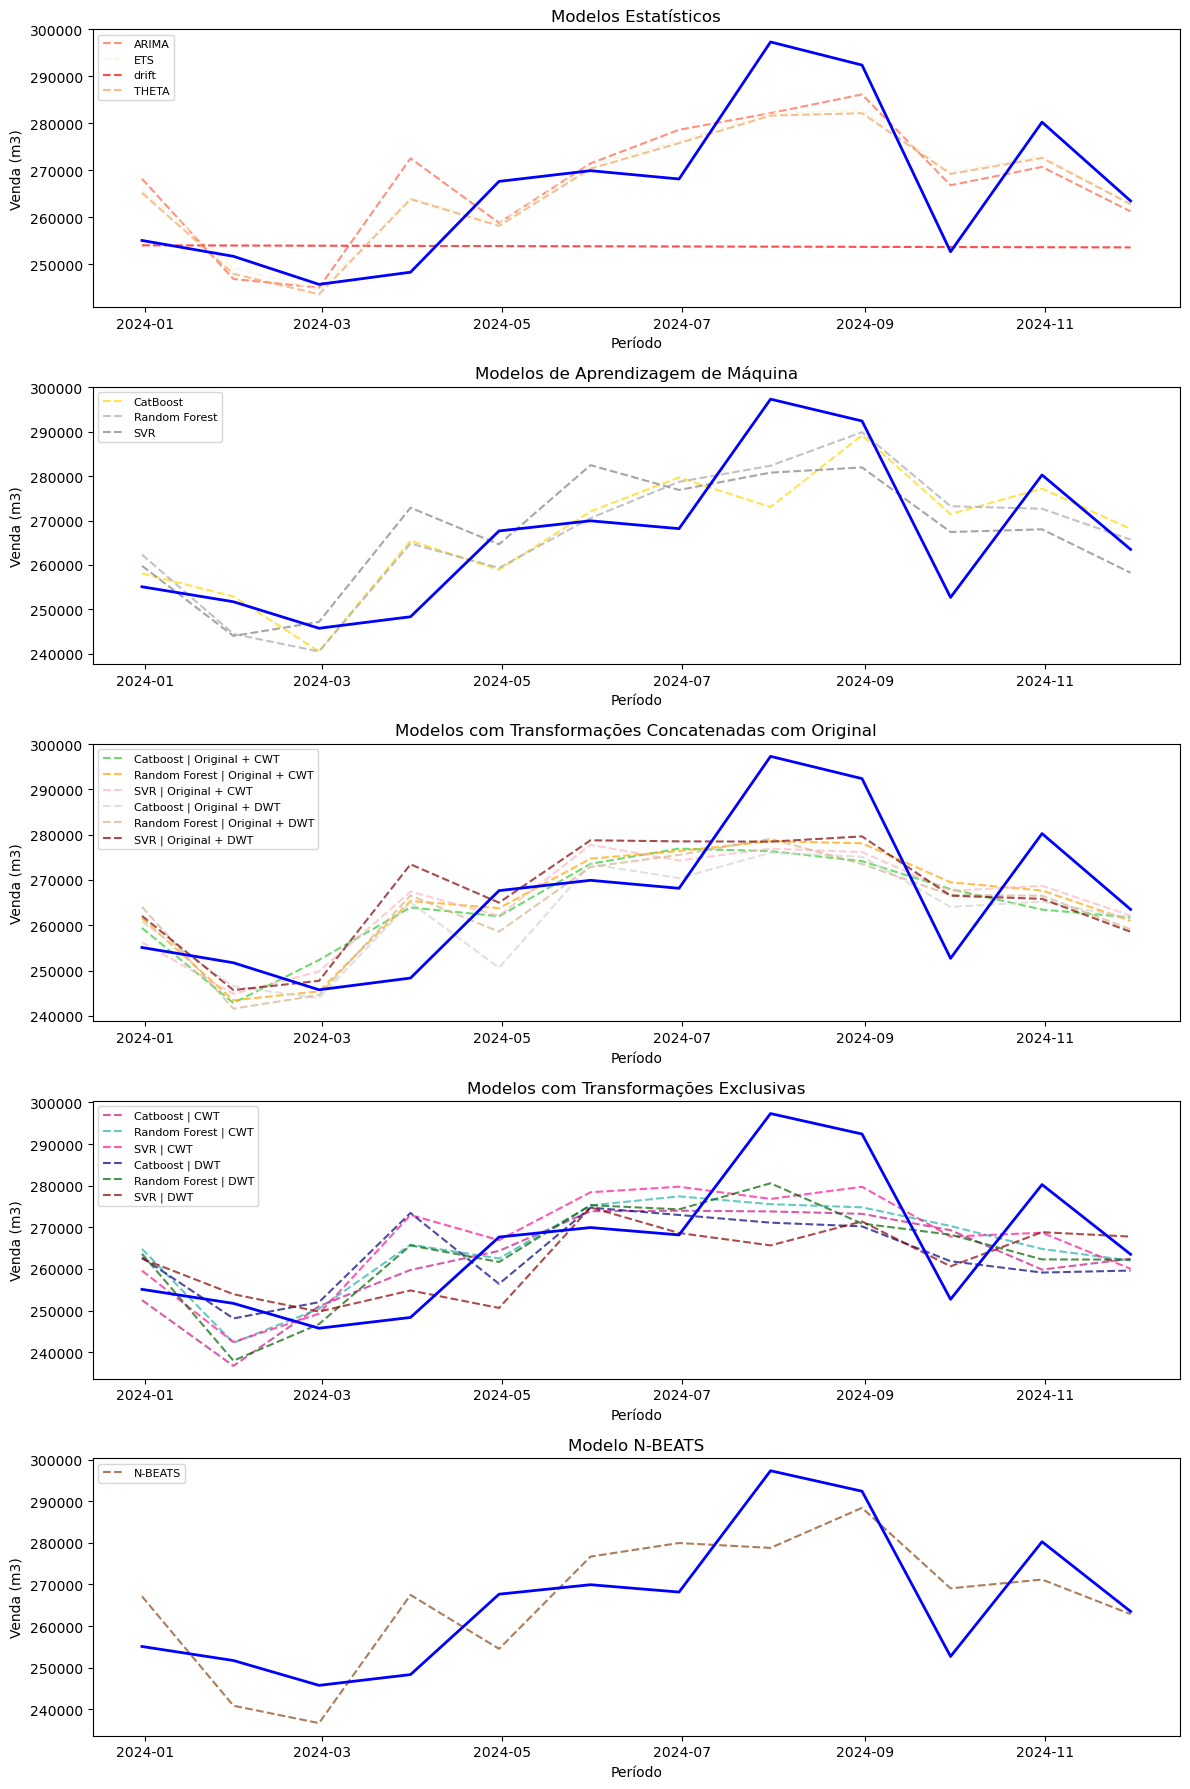

In [ ]:
from ast import literal_eval
from Statistics_and_Seq2Seq.all_functions import *
import os
from cisia.datasets import DatasetLoader
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.clustering.averaging import elastic_barycenter_average
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
index = 120
horizon = 12
date_target = '2024-11-30'
df_arima = pd.read_csv('./timeseries/mestrado/resultados/ARIMA/normal/ANP_MONTHLY.csv', sep=";")
df_arima = df_arima[df_arima['dataset_index'] == index]
df_arima = df_arima[df_arima['final_test'] == date_target]

df_catboost = pd.read_csv('./timeseries/mestrado/resultados/catboost/normal/ANP_MONTHLY.csv', sep=";")
df_catboost = df_catboost[df_catboost['dataset_index'] == index]
df_catboost = df_catboost[df_catboost['final_test'] == date_target]

df_cwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/CWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
df_cwt_catboost = df_cwt_catboost[df_cwt_catboost['dataset_index'] == index]
df_cwt_catboost = df_cwt_catboost[df_cwt_catboost['final_test'] == date_target]

df_cwt_rf = pd.read_csv('./timeseries/mestrado/resultados/CWT_rf/normal/ANP_MONTHLY.csv', sep=";")
df_cwt_rf = df_cwt_rf[df_cwt_rf['dataset_index'] == index]
df_cwt_rf = df_cwt_rf[df_cwt_rf['final_test'] == date_target]

df_cwt_svr = pd.read_csv('./timeseries/mestrado/resultados/CWT_svr/normal/ANP_MONTHLY.csv', sep=";")
df_cwt_svr = df_cwt_svr[df_cwt_svr['dataset_index'] == index]
df_cwt_svr = df_cwt_svr[df_cwt_svr['final_test'] == date_target]

df_dwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/DWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
df_dwt_catboost = df_dwt_catboost[df_dwt_catboost['dataset_index'] == index]
df_dwt_catboost = df_dwt_catboost[df_dwt_catboost['final_test'] == date_target]

df_dwt_rf = pd.read_csv('./timeseries/mestrado/resultados/DWT_rf/normal/ANP_MONTHLY.csv', sep=";")
df_dwt_rf = df_dwt_rf[df_dwt_rf['dataset_index'] == index]
df_dwt_rf = df_dwt_rf[df_dwt_rf['final_test'] == date_target]

df_dwt_svr = pd.read_csv('./timeseries/mestrado/resultados/DWT_svr/normal/ANP_MONTHLY.csv', sep=";")
df_dwt_svr = df_dwt_svr[df_dwt_svr['dataset_index'] == index]
df_dwt_svr = df_dwt_svr[df_dwt_svr['final_test'] == date_target]

df_ets = pd.read_csv('./timeseries/mestrado/resultados/ETS/normal/ANP_MONTHLY.csv', sep=";")
df_ets = df_ets[df_ets['dataset_index'] == index]
df_ets = df_ets[df_ets['final_test'] == date_target]

df_naivemoving = pd.read_csv('./timeseries/mestrado/resultados/NaiveMovingAverage/normal/ANP_MONTHLY.csv', sep=";")
df_naivemoving = df_naivemoving[df_naivemoving['dataset_index'] == index]
df_naivemoving = df_naivemoving[df_naivemoving['final_test'] == date_target]

df_drift = pd.read_csv('./timeseries/mestrado/resultados/NaiveDrift/normal/ANP_MONTHLY.csv', sep=";")
df_drift = df_drift[df_drift['dataset_index'] == index]
df_drift = df_drift[df_drift['final_test'] == date_target]

df_naiveseasonal = pd.read_csv('./timeseries/mestrado/resultados/NaiveSeasonal/normal/ANP_MONTHLY.csv', sep=";")
df_naiveseasonal = df_naiveseasonal[df_naiveseasonal['dataset_index'] == index]
df_naiveseasonal = df_naiveseasonal[df_naiveseasonal['final_test'] == date_target]

df_nbeats = pd.read_csv('./timeseries/mestrado/resultados/NBEATS/normal/ANP_MONTHLY.csv', sep=";")
df_nbeats = df_nbeats[df_nbeats['dataset_index'] == index]
df_nbeats = df_nbeats[df_nbeats['final_test'] == date_target]

df_only_cwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/ONLY_CWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
df_only_cwt_catboost = df_only_cwt_catboost[df_only_cwt_catboost['dataset_index'] == index]
df_only_cwt_catboost = df_only_cwt_catboost[df_only_cwt_catboost['final_test'] == date_target]

df_only_cwt_rf = pd.read_csv('./timeseries/mestrado/resultados/ONLY_CWT_rf/normal/ANP_MONTHLY.csv', sep=";")
df_only_cwt_rf = df_only_cwt_rf[df_only_cwt_rf['dataset_index'] == index]
df_only_cwt_rf = df_only_cwt_rf[df_only_cwt_rf['final_test'] == date_target]

df_only_cwt_svr = pd.read_csv('./timeseries/mestrado/resultados/ONLY_CWT_svr/normal/ANP_MONTHLY.csv', sep=";")
df_only_cwt_svr = df_only_cwt_svr[df_only_cwt_svr['dataset_index'] == index]
df_only_cwt_svr = df_only_cwt_svr[df_only_cwt_svr['final_test'] == date_target]

df_only_dwt_catboost = pd.read_csv('./timeseries/mestrado/resultados/ONLY_DWT_catboost/normal/ANP_MONTHLY.csv', sep=";")
df_only_dwt_catboost = df_only_dwt_catboost[df_only_dwt_catboost['dataset_index'] == index]
df_only_dwt_catboost = df_only_dwt_catboost[df_only_dwt_catboost['final_test'] == date_target]

df_only_dwt_rf = pd.read_csv('./timeseries/mestrado/resultados/ONLY_DWT_rf/normal/ANP_MONTHLY.csv', sep=";")
df_only_dwt_rf = df_only_dwt_rf[df_only_dwt_rf['dataset_index'] == index]
df_only_dwt_rf = df_only_dwt_rf[df_only_dwt_rf['final_test'] == date_target]

df_only_dwt_svr = pd.read_csv('./timeseries/mestrado/resultados/ONLY_DWT_svr/normal/ANP_MONTHLY.csv', sep=";")
df_only_dwt_svr = df_only_dwt_svr[df_only_dwt_svr['dataset_index'] == index]
df_only_dwt_svr = df_only_dwt_svr[df_only_dwt_svr['final_test'] == date_target]

df_rf = pd.read_csv('./timeseries/mestrado/resultados/rf/normal/ANP_MONTHLY.csv', sep=";")
df_rf = df_rf[df_rf['dataset_index'] == index]
df_rf = df_rf[df_rf['final_test'] == date_target]

df_svr = pd.read_csv('./timeseries/mestrado/resultados/svr/normal/ANP_MONTHLY.csv', sep=";")
df_svr = df_svr[df_svr['dataset_index'] == index]
df_svr = df_svr[df_svr['final_test'] == date_target]

df_theta = pd.read_csv('./timeseries/mestrado/resultados/THETA/normal/ANP_MONTHLY.csv', sep=";")
df_theta = df_theta[df_theta['dataset_index'] == index]
df_theta = df_theta[df_theta['final_test'] == date_target]

df_ft_rf = pd.read_csv('./timeseries/mestrado/resultados/FT_rf/normal/ANP_MONTHLY.csv', sep=";")
df_ft_rf = df_ft_rf[df_ft_rf['dataset_index'] == index]
df_ft_rf = df_ft_rf[df_ft_rf['final_test'] == date_target]

df_ft_catboost = pd.read_csv('./timeseries/mestrado/resultados/FT_catboost/normal/ANP_MONTHLY.csv', sep=";")
df_ft_catboost = df_ft_catboost[df_ft_catboost['dataset_index'] == index]
df_ft_catboost = df_ft_catboost[df_ft_catboost['final_test'] == date_target]

df_ft_svr = pd.read_csv('./timeseries/mestrado/resultados/FT_svr/normal/ANP_MONTHLY.csv', sep=";")
df_ft_svr = df_ft_svr[df_ft_svr['dataset_index'] == index]
df_ft_svr = df_ft_svr[df_ft_svr['final_test'] == date_target]

df_only_ft_rf = pd.read_csv('./timeseries/mestrado/resultados/ONLY_FT_rf/normal/ANP_MONTHLY.csv', sep=";")
df_only_ft_rf = df_only_ft_rf[df_only_ft_rf['dataset_index'] == index]
df_only_ft_rf = df_only_ft_rf[df_only_ft_rf['final_test'] == date_target]

df_only_ft_catboost = pd.read_csv('./timeseries/mestrado/resultados/ONLY_FT_catboost/normal/ANP_MONTHLY.csv', sep=";")
df_only_ft_catboost = df_only_ft_catboost[df_only_ft_catboost['dataset_index'] == index]
df_only_ft_catboost = df_only_ft_catboost[df_only_ft_catboost['final_test'] == date_target]

df_only_ft_svr = pd.read_csv('./timeseries/mestrado/resultados/ONLY_FT_svr/normal/ANP_MONTHLY.csv', sep=";")
df_only_ft_svr = df_only_ft_svr[df_only_ft_svr['dataset_index'] == index]
df_only_ft_svr = df_only_ft_svr[df_only_ft_svr['final_test'] == date_target]


# df_rf['test'] = df_rf['test'].str.replace(r'\s+', ', ', regex=True)  # Corrige os espaços para vírgulas
# test = df_rf['test'].apply(literal_eval)[0]

loader = DatasetLoader()
# result, flag = loader.sales_monthly_state()
# print(flag)
df_original, metadata = loader.read_tsf(path_tsf='./mes_11_venda_mensal.tsf')
series_value = df_original.iloc[index]['series_value'].tolist()
start_timestamp = df_original.iloc[index]['start_timestamp']
index_series = pd.date_range(start=start_timestamp, periods=len(series_value), freq="M")

pd_series = pd.Series(series_value, index=index_series)
_, get = pd_series[:-horizon], pd_series[-horizon:]

test = df_rf['test'].apply(literal_eval).tolist()[0]
test = pd.Series(test, index=get.index)

pred_arima = get_preds_column(df_arima, get.index)
pred_naivedrift = get_preds_column(df_drift, get.index)
pred_catboost = get_preds_column(df_catboost, get.index)
pred_cwt_catboost = get_preds_column(df_cwt_catboost, get.index)
pred_cwt_rf = get_preds_column(df_cwt_rf, get.index)
pred_cwt_svr = get_preds_column(df_cwt_svr, get.index)
pred_dwt_catboost = get_preds_column(df_dwt_catboost, get.index)
pred_dwt_rf = get_preds_column(df_dwt_rf, get.index)
pred_dwt_svr = get_preds_column(df_dwt_svr, get.index)
pred_ets = get_preds_column(df_ets, get.index)
pred_naivemoving = get_preds_column(df_naivemoving, get.index)
pred_naiveseasonal = get_preds_column(df_naiveseasonal, get.index)
pred_nbeats = get_preds_column(df_nbeats, get.index)

pred_only_cwt_catboost = get_preds_column(df_only_cwt_catboost, get.index)
pred_only_cwt_rf = get_preds_column(df_only_cwt_rf, get.index)
pred_only_cwt_svr = get_preds_column(df_only_cwt_svr, get.index)

pred_only_dwt_catboost = get_preds_column(df_only_dwt_catboost, get.index)
pred_only_dwt_rf = get_preds_column(df_only_dwt_rf, get.index)
pred_only_dwt_svr = get_preds_column(df_only_dwt_svr, get.index)

pred_rf = get_preds_column(df_rf, get.index)
pred_svr = get_preds_column(df_svr, get.index)
pred_theta = get_preds_column(df_theta, get.index)

pred_ft_rf = get_preds_column(df_ft_rf, get.index)
pred_ft_catboost = get_preds_column(df_ft_catboost, get.index)
pred_ft_svr = get_preds_column(df_ft_svr, get.index)

pred_only_ft_rf = get_preds_column(df_only_ft_rf, get.index)
pred_only_ft_catboost = get_preds_column(df_only_ft_catboost, get.index)
pred_only_ft_svr = get_preds_column(df_only_ft_svr, get.index)


pred_mean = calculate_mean_prediction(
pred_arima, pred_catboost, pred_cwt_rf,
pred_cwt_svr, pred_dwt_catboost, pred_dwt_svr,
pred_ets, pred_naivemoving, pred_naiveseasonal,
pred_nbeats, pred_only_cwt_catboost, pred_only_cwt_rf, pred_only_cwt_svr,
pred_only_dwt_catboost, pred_only_dwt_rf, pred_only_dwt_svr,
pred_rf, pred_svr, pred_theta,
pred_ft_rf,pred_ft_catboost,pred_ft_svr,
pred_only_ft_rf, pred_only_ft_catboost, pred_only_ft_svr
)

pred_median = calculate_median_prediction(
pred_arima, pred_catboost, pred_cwt_rf,
pred_cwt_svr, pred_dwt_catboost, pred_dwt_svr,
pred_ets, pred_naivemoving, pred_naiveseasonal,
pred_nbeats, pred_only_cwt_catboost, pred_only_cwt_rf, pred_only_cwt_svr,
pred_only_dwt_catboost, pred_only_dwt_rf, pred_only_dwt_svr,
pred_rf, pred_svr, pred_theta
)

import matplotlib.pyplot as plt

# Criando os subgráficos (5 linhas e 1 coluna)
fig, axs = plt.subplots(5, 1, figsize=(12, 18))  # Ajuste o tamanho da figura para acomodar os subgráficos

# Subgráfico 1: Modelos Estatísticos
axs[0].plot(pred_arima, label='ARIMA', linestyle='--', color='#FF6347', alpha=0.7)  # Vermelho Claro
axs[0].plot(pred_ets, label='ETS', linestyle='--', color='#F5F5DC', alpha=0.7)  # Bege
axs[0].plot(pred_naivedrift, label='drift', linestyle='--', color='red', alpha=0.7)  # Bege
axs[0].plot(pred_theta, label='THETA', linestyle='--', color='#F4A460', alpha=0.7)  # Areia
axs[0].set_title('Modelos Estatísticos')
axs[0].set_xlabel('Período')
axs[0].set_ylabel('Venda (m3)')
axs[0].legend(loc='upper left', fontsize=8)

# Subgráfico 2: Modelos de Aprendizagem de Máquina
axs[1].plot(pred_catboost, label='CatBoost', linestyle='--', color='#FFD700', alpha=0.7)  # Amarelo Ouro
axs[1].plot(pred_rf, label='Random Forest', linestyle='--', color='#A9A9A9', alpha=0.7)  # Cinza Escuro
axs[1].plot(pred_svr, label='SVR', linestyle='--', color='#808080', alpha=0.7)  # Cinza
axs[1].set_title('Modelos de Aprendizagem de Máquina')
axs[1].set_xlabel('Período')
axs[1].set_ylabel('Venda (m3)')
axs[1].legend(loc='upper left', fontsize=8)

# Subgráfico 3: Modelos com Transformações Concatenadas com Original (CWT e DWT)
axs[2].plot(pred_cwt_catboost, label='Catboost | Original + CWT', linestyle='--', color='#32CD32', alpha=0.7)  # Verde Limão
axs[2].plot(pred_cwt_rf, label='Random Forest | Original + CWT', linestyle='--', color='#FFA500', alpha=0.7)  # Laranja
axs[2].plot(pred_cwt_svr, label='SVR | Original + CWT', linestyle='--', color='#FFB6C1', alpha=0.7)  # Rosa Claro
axs[2].plot(pred_dwt_catboost, label='Catboost | Original + DWT', linestyle='--', color='#D3D3D3', alpha=0.7)  # Cinza Claro
axs[2].plot(pred_dwt_rf, label='Random Forest | Original + DWT', linestyle='--', color='#D2B48C', alpha=0.7)  # Marrom Claro
axs[2].plot(pred_dwt_svr, label='SVR | Original + DWT', linestyle='--', color='#800000', alpha=0.7)  # Bordô
axs[2].set_title('Modelos com Transformações Concatenadas com Original')
axs[2].set_xlabel('Período')
axs[2].set_ylabel('Venda (m3)')
axs[2].legend(loc='upper left', fontsize=8)

# Subgráfico 4: Modelos com Transformações Exclusivas (CWT e DWT)
axs[3].plot(pred_only_cwt_catboost, label='Catboost | CWT', linestyle='--', color='#C71585', alpha=0.7)  # Violeta
axs[3].plot(pred_only_cwt_rf, label='Random Forest | CWT', linestyle='--', color='#20B2AA', alpha=0.7)  # Verde Água
axs[3].plot(pred_only_cwt_svr, label='SVR | CWT', linestyle='--', color='#FF1493', alpha=0.7)  # Rosa Escuro
axs[3].plot(pred_only_dwt_catboost, label='Catboost | DWT', linestyle='--', color='#000080', alpha=0.7)  # Azul Marinho
axs[3].plot(pred_only_dwt_rf, label='Random Forest | DWT', linestyle='--', color='#006400', alpha=0.7)  # Verde Escuro
axs[3].plot(pred_only_dwt_svr, label='SVR | DWT', linestyle='--', color='#8B0000', alpha=0.7)  # Vermelho Escuro
axs[3].set_title('Modelos com Transformações Exclusivas')
axs[3].set_xlabel('Período')
axs[3].set_ylabel('Venda (m3)')
axs[3].legend(loc='upper left', fontsize=8)

# Subgráfico 5: Modelo N-BEATS
axs[4].plot(pred_nbeats, label='N-BEATS', linestyle='--', color='#8B4513', alpha=0.7)  # Marrom Escuro
axs[4].set_title('Modelo N-BEATS')
axs[4].set_xlabel('Período')
axs[4].set_ylabel('Venda (m3)')
axs[4].legend(loc='upper left', fontsize=8)

# Adicionando o gráfico do Teste (em todos os subgráficos)
for ax in axs:
    ax.plot(test, label='Test', color='blue', linewidth=2)

# Ajustando layout e removendo bordas extras
plt.tight_layout()

# Salvando o gráfico em um arquivo PDF
plt.savefig('resultados_por_categoria.pdf', bbox_inches='tight')

# Exibindo o gráfico
plt.show()



In [14]:
loader = DatasetLoader()
# result, flag = loader.sales_monthly_state()
# print(flag)
df, metadata = loader.read_tsf(path_tsf='./mes_11_venda_mensal.tsf')

i = 143

frequency = metadata['frequency']
horizon = metadata['horizon']
transform = "normal"

In [3]:

series_value = df.iloc[i]['series_value'].tolist()

start_timestamp = df.iloc[i]['start_timestamp']

freq = "ME" if frequency == "monthly" else "Y"

index_series = pd.date_range(start=start_timestamp, periods=len(series_value), freq=freq)
pd_series = pd.Series(series_value, index=index_series)
# series = TimeSeries.from_series(pd_series)

train, test = pd_series[:-horizon], pd_series[-horizon:]

#normalizacao para estatisticos
train_tf, _, _ = rolling_window_series(train, horizon)

train_darts = TimeSeries.from_series(train_tf)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


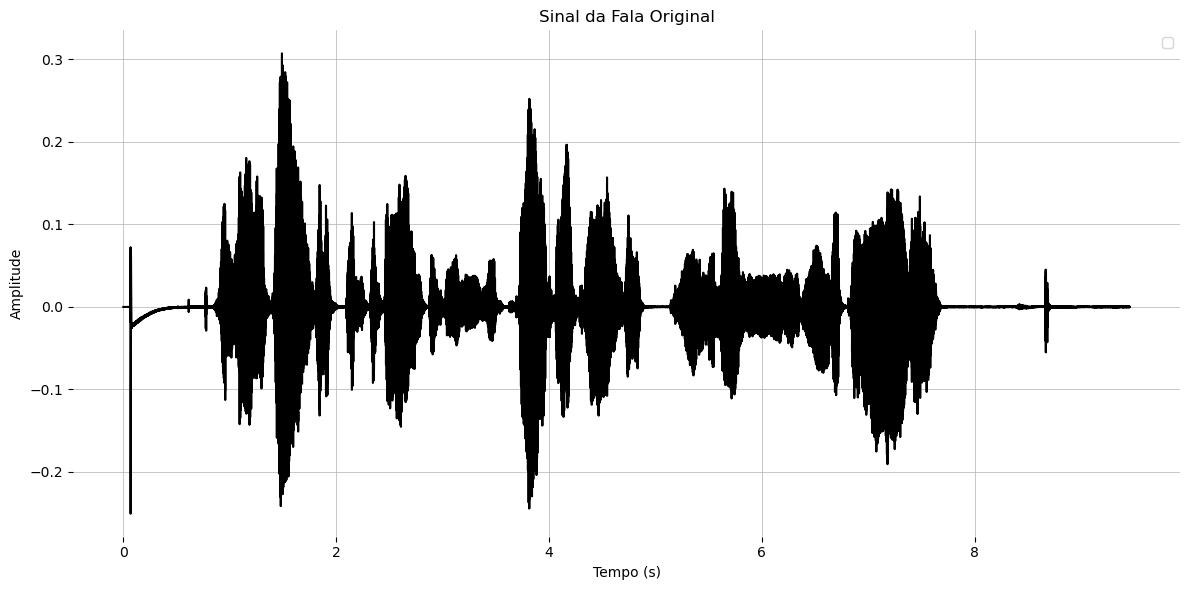

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


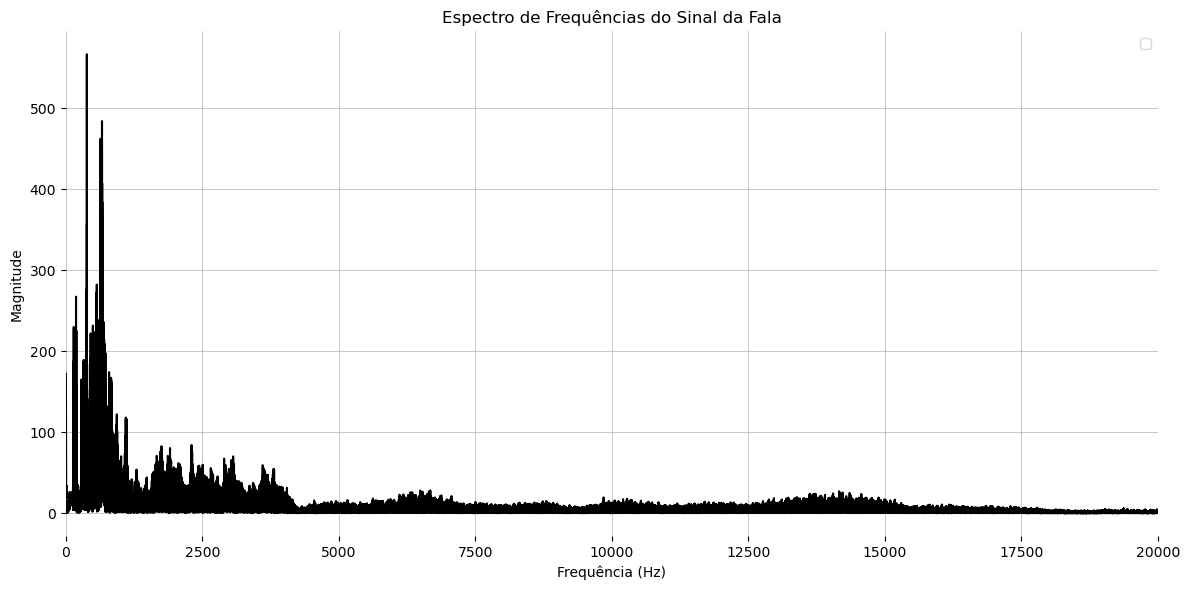

In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

audio_path = '/home/user/lucas/my_voice.wav'
signal, sr = librosa.load(audio_path, sr=None) 
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, len(signal)/sr, len(signal)), signal,  color='k')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal da Fala Original')
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/sr)

positive_freqs = frequencies[frequencies >= 0]
positive_fft_values = np.abs(fft_values[frequencies >= 0])

#limite o eixo x até 20kHz
plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, positive_fft_values, color='k')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequências do Sinal da Fala')
plt.legend()
plt.xlim(0, 20000)
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

pd_correto = pd_series

decomposition = seasonal_decompose(pd_correto, model='additive')  
trend = decomposition.trend       #  tendência
seasonal = decomposition.seasonal #  sazonalidade
residual = decomposition.resid    #  resíduo (ruído)
deseasonalized = pd_correto - seasonal
cycle, trend_hp = hpfilter(deseasonalized, lamb=1600)

plt.figure(figsize=(10, 4))
plt.plot(pd_correto, color='blue')
plt.xlabel('Observações no tempo')
plt.ylabel('Vendas em m³')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(trend, color='orange')
plt.xlabel('Tendência no tempo')
plt.ylabel('Tendência em m³')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(seasonal, color='green')
plt.xlabel('Sazonalidade no tempo')
plt.ylabel('Sazonalidade em m³')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(residual, color='red')
plt.xlabel('Ruído no tempo')
plt.ylabel('Ruído em m³')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cycle, color='brown')
plt.xlabel('Ciclo no tempo')
plt.ylabel('Ciclo em m³')
plt.legend()
plt.show()

NameError: name 'pd_series' is not defined

In [8]:
def generate_error_series():    
    min_train_size = horizon * 2
    all_preds = pd.Series(dtype=float)
    all_test = pd.Series(dtype=float)
    all_errors = pd.Series(dtype=float)
    # from Statistics_and_Seq2Seq.all_functions import *
    window = 12
    representation, wavelet, level = "MTF", "morl", 1
    n_partes = 1

    min_train_size = 36 + (12 * 15)
    train_test_splits = []
    aux_series = train
    while len(aux_series) > horizon + min_train_size:
        train_val, test_val = aux_series[:-horizon], aux_series[-horizon:]
        train_test_splits.append((train_val, test_val))
        aux_series = train_val
    
    for (train_val, test_val) in train_test_splits:

        print(f"Iteração: Data range do conjunto de treino: {train_val.index[0]} - {train_val.index[-1]}")
        train_tf_val, _, _ = rolling_window_series(train_val, horizon)

        
        train_tf_val_darts = TimeSeries.from_series(train_tf_val)

        model = StatsForecastAutoETS(season_length=12)
        model.fit(train_tf_val_darts)

        result_val = model.predict(n=horizon)
        preds_val_norm = pd.Series(result_val.values().flatten().tolist(), index=test_val.index)

        preds_val_real = reverse_transform_norm_preds(preds_val_norm, train_val, transform)
        all_preds = pd.concat([all_preds, preds_val_real])
        all_preds = all_preds.sort_index()

        all_test = pd.concat([all_test, test_val])
        all_test = all_test.sort_index()

        all_errors = all_test - all_preds


    # all_errors.index = all_errors.index.to_period('M')
    all_errors.index = pd.to_datetime(all_errors.index)
    all_errors.index = all_errors.index.to_period('M') 
    data = rolling_window_image(pd.concat([all_errors, pd.Series([0] * horizon, index=test.index)]), window, representation, wavelet, level)
                    
    data = data.dropna()
    mean_data_error = np.mean(data)
    std_data_error = np.mean(np.std(data))
    print(std_data_error)
    if std_data_error == 0:
        return pd.Series([0] * horizon, index=test.index)
    
    X_train, X_test, y_train, _ = train_test_split(data, horizon)


    results_rg = {'iterations': 200, 'learning_rate': 0.01018185095858352, 'depth': 4, 'loss_function': 'RMSE', 'random_state': 42}
    rg = CatBoostRegressor(**results_rg)
    # results_rg = {'alphas': np.logspace(-3, 3, 10)}
    # rg = RidgeCV(**results_rg)
    rg.fit(X_train, y_train)

    # train_val2 = train_val
    # train_val2.index = train_val2.index.to_period('M')

    predictions_error = recursive_2(X_test, all_errors, rg, horizon, window, transform, representation, wavelet, level)
    preds_real_error = pd.Series(predictions_error, index=test.index)

    return preds_real_error

preds_real_error = generate_error_series()

Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2022-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2021-11-30 00:00:00


/tmp/ipykernel_1794039/286728182.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_preds = pd.concat([all_preds, preds_val_real])
/tmp/ipykernel_1794039/286728182.py:37: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_test = pd.concat([all_test, test_val])


Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2020-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2019-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2018-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2017-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2016-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2015-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2014-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2013-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2012-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2011-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31 00:00:00 - 2010-11-30 00:00:00
Iteração: Data range do conjunto de treino: 1990-01-31

/home/user/miniconda3/envs/darts_exp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


0.29748298433155823
0:	learn: 1.3815205	total: 49.7ms	remaining: 9.9s
1:	learn: 1.3792687	total: 51.5ms	remaining: 5.09s
2:	learn: 1.3777967	total: 54.3ms	remaining: 3.57s
3:	learn: 1.3764458	total: 56.7ms	remaining: 2.78s
4:	learn: 1.3752279	total: 59.7ms	remaining: 2.33s
5:	learn: 1.3733962	total: 62.5ms	remaining: 2.02s
6:	learn: 1.3718542	total: 64.8ms	remaining: 1.79s
7:	learn: 1.3706063	total: 67ms	remaining: 1.61s
8:	learn: 1.3684542	total: 69.3ms	remaining: 1.47s
9:	learn: 1.3658315	total: 71.7ms	remaining: 1.36s
10:	learn: 1.3649539	total: 74.6ms	remaining: 1.28s
11:	learn: 1.3630950	total: 76.2ms	remaining: 1.19s
12:	learn: 1.3609904	total: 78.5ms	remaining: 1.13s
13:	learn: 1.3595067	total: 80.7ms	remaining: 1.07s
14:	learn: 1.3582768	total: 83ms	remaining: 1.02s
15:	learn: 1.3570024	total: 85.9ms	remaining: 988ms
16:	learn: 1.3548429	total: 88.1ms	remaining: 949ms
17:	learn: 1.3525754	total: 91ms	remaining: 920ms
18:	learn: 1.3508681	total: 93.3ms	remaining: 889ms
19:	learn

/tmp/ipykernel_1794039/3252575102.py:225: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_real = reverse_regressors(train_completo, last_pd, window, format=transform)[-1]
/tmp/ipykernel_1794039/3252575102.py:225: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_real = reverse_regressors(train_completo, last_pd, window, format=transform)[-1]
/tmp/ipykernel_1794039/3252575102.py:225: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

In [9]:
model = StatsForecastAutoETS(season_length=12)
model.fit(train_darts)


StatsForecastAutoETS(add_encoders=None, season_length=12)

In [10]:
result = model.predict(n=horizon)
preds_norm = pd.Series(result.values().flatten().tolist(), index=test.index)

#para modelos estatisticos
preds_real = reverse_transform_norm_preds(preds_norm, train, transform)
preds_real

2023-12-31    56056.902124
2024-01-31    48356.551817
2024-02-29    47924.396135
2024-03-31    51436.630746
2024-04-30    51112.138767
2024-05-31    52213.818242
2024-06-30    51761.019413
2024-07-31    52699.617045
2024-08-31    55341.281555
2024-09-30    53634.432697
2024-10-31    55267.508516
2024-11-30    52284.951466
Freq: ME, dtype: float64

In [11]:
preds_real_array = np.array(preds_real.values)
preds_real_reshaped = preds_real_array.reshape(1, -1)
test_reshaped = test.values.reshape(1, -1)
smape_result = calculate_smape(preds_real_reshaped, test_reshaped)
rmse_result = calculate_rmse(preds_real_reshaped, test_reshaped)
msmape_result = calculate_msmape(preds_real_reshaped, test_reshaped)
mae_result = calculate_mae(preds_real_reshaped, test_reshaped)
mape_result = mape(test.values, preds_real_array)
pocid_result = pocid(test.values, preds_real_array)

print("MAPE: ", mape_result)
print("SMAPE: ", smape_result)
print("MSMAPE: ", msmape_result)
print("RMSE: ", rmse_result)
print("MAE: ", mae_result)
print("POCID: ", pocid_result)

MAPE:  0.0408528049158473
SMAPE:  [0.04021576]
MSMAPE:  [0.04021572]
RMSE:  [2389.64958355]
MAE:  [2064.51914675]
POCID:  72.72727272727273


In [12]:
preds_combined = preds_real + preds_real_error

In [13]:
print('PREDS + ERROS')
preds_real_array = np.array(preds_combined.values)
preds_real_reshaped = preds_real_array.reshape(1, -1)
test_reshaped = test.values.reshape(1, -1)
smape_result = calculate_smape(preds_real_reshaped, test_reshaped)
rmse_result = calculate_rmse(preds_real_reshaped, test_reshaped)
msmape_result = calculate_msmape(preds_real_reshaped, test_reshaped)
mae_result = calculate_mae(preds_real_reshaped, test_reshaped)
mape_result = mape(test.values, preds_real_array)
pocid_result = pocid(test.values, preds_real_array)

print("MAPE: ", mape_result)
print("SMAPE: ", smape_result)
print("MSMAPE: ", msmape_result)
print("RMSE: ", rmse_result)
print("MAE: ", mae_result)
print("POCID: ", pocid_result)

PREDS + ERROS
MAPE:  0.04007462051110843
SMAPE:  [0.04061755]
MSMAPE:  [0.04061751]
RMSE:  [2389.1986763]
MAE:  [2082.44178698]
POCID:  72.72727272727273


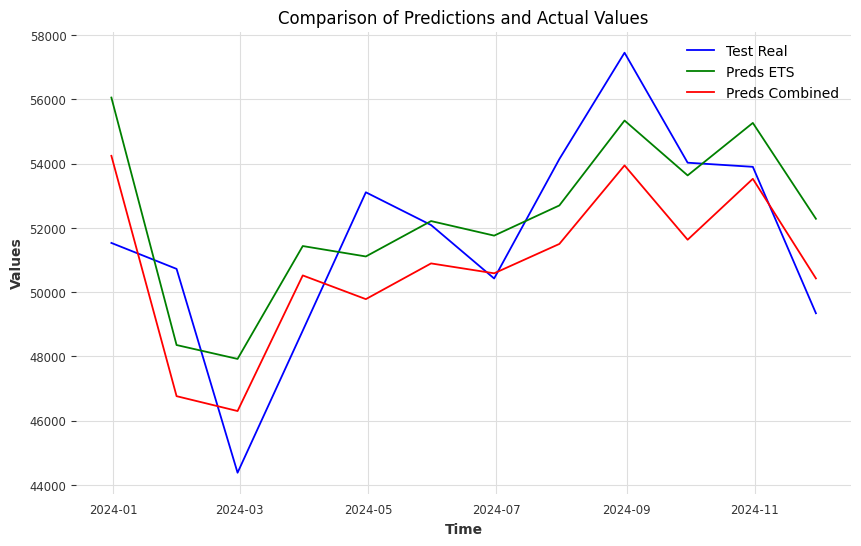

In [14]:
import matplotlib.pyplot as plt

# Suposições: preds_combined, preds_real, e test são pd.Series com índices coerentes
# Plotando as séries

plt.figure(figsize=(10, 6))
plt.plot(test, label='Test Real', color='blue')
plt.plot(preds_real, label='Preds ETS', color='green')
plt.plot(preds_combined, label='Preds Combined', color='red')

plt.title('Comparison of Predictions and Actual Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()
